This model illustrates one possible way to classify basic emotions using LOCAL BINARY PATTERN method, and combining it with SVM and trees in order to get good models. 

In [1]:
import pandas as pd
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split, GridSearchCV
from skimage import feature
from sklearn.preprocessing import StandardScaler
from sklearn import multiclass
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report

In [2]:
# Using methods from other notebook
%run preprocessing_functions.ipynb

In [3]:
# Loading ck+ dataset
images, labels = load_data('datasets/ck+')

In [4]:
# As we see, this dataset consists of 327 images of 48 x 48 px
images.shape

(327, 48, 48)

In [5]:
# We don't want to normalize values because LBP preprocessing works better with values between 0 - 255
print(images[0])

[[36  8  2 ... 25 48 64]
 [12  3  2 ... 11 29 61]
 [ 4  2  1 ... 11 16 54]
 ...
 [68 68 67 ... 78 78 77]
 [68 68 69 ... 78 77 77]
 [66 67 69 ... 76 77 76]]


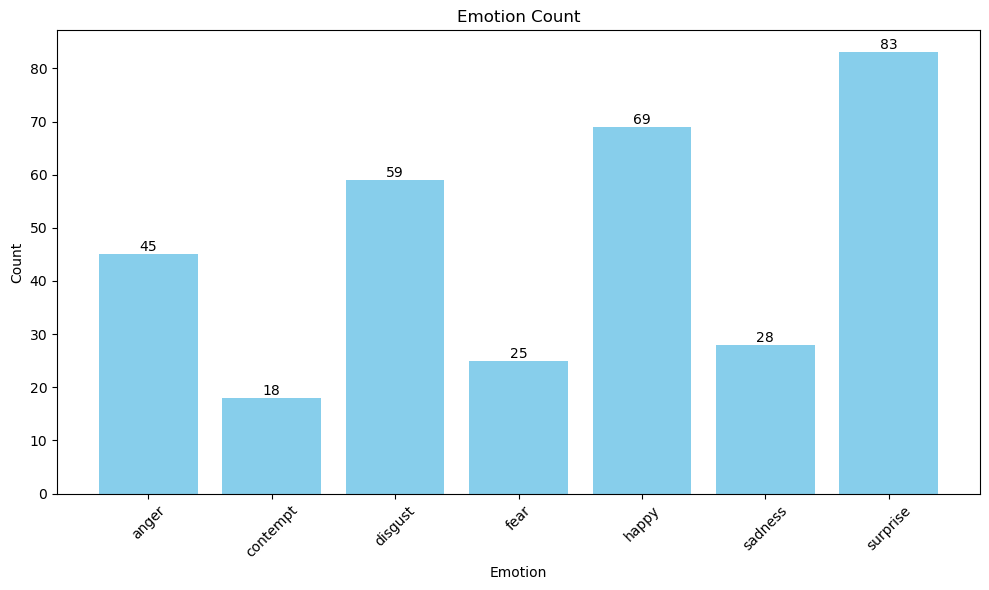

In [6]:
# We have unabalanced dataset, where emotion contempt has only 18 instances, while surprise have 83. One way to 
# balance this dataset is to create new instances of smaller classes

plot_count(images, labels)

In [7]:
# One possible way to make more data is to add mirrored images of faces, the face will still represent same emotion
# but we'll have somewhere different image

images, labels = add_mirror_images(images, labels, ["anger", "surprise", "disgust", "happy"])

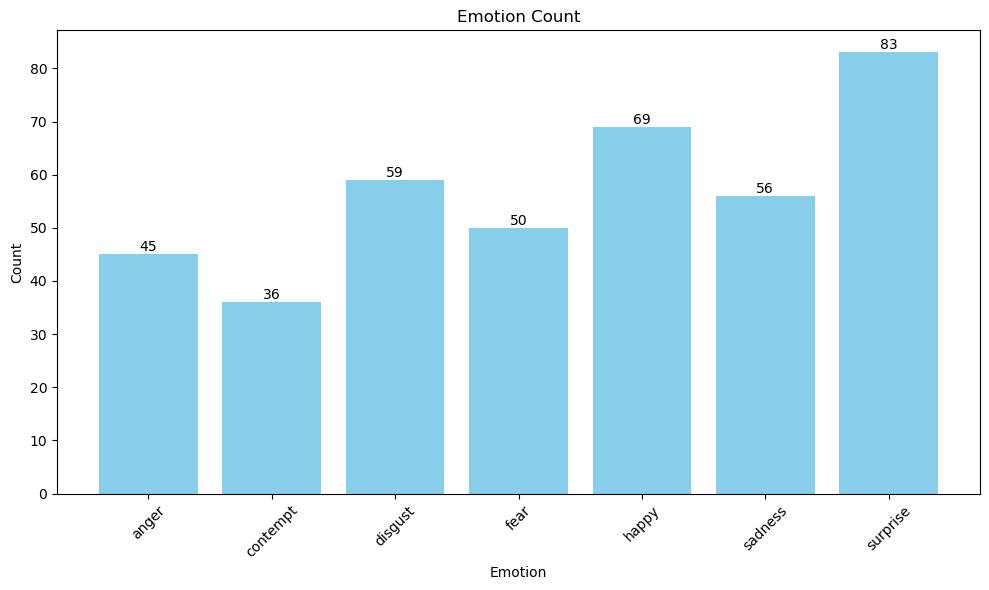

In [8]:
# We generated new instances, but the dataset is still unbalanced to some point because now we have classes with 
# more instances than the rest

plot_count(images, labels)

In [9]:
# One way to fix this is to randomly delete some of the instances from these classes
seed = 12
images, labels = random_delete_upto(images, labels, "disgust", 55, seed)
images, labels = random_delete_upto(images, labels, "happy", 55, seed)
images, labels = random_delete_upto(images, labels, "sadness", 55, seed)
images, labels = random_delete_upto(images, labels, "surprise", 55, seed)

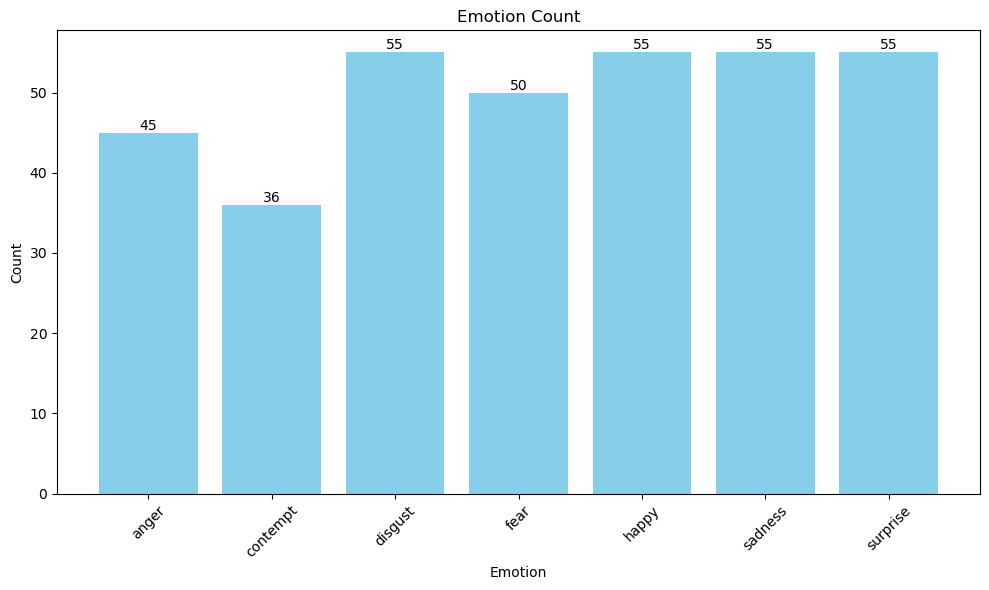

In [10]:
# Now the dataset looks more balanced

plot_count(images, labels)

In [11]:
images.shape

(351, 48, 48)

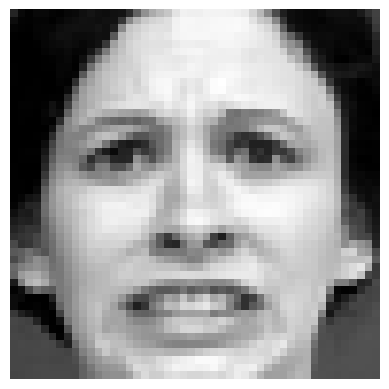

fear


In [12]:
plot_image(images[0], labels[0])

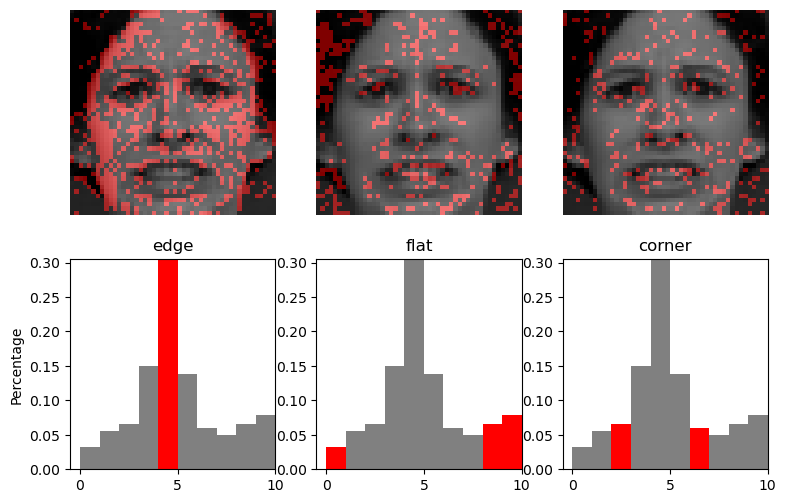

In [13]:
# For showing how lbp works

# Firstly, with radius 1 

plot_lbp_example(images[0], 1)

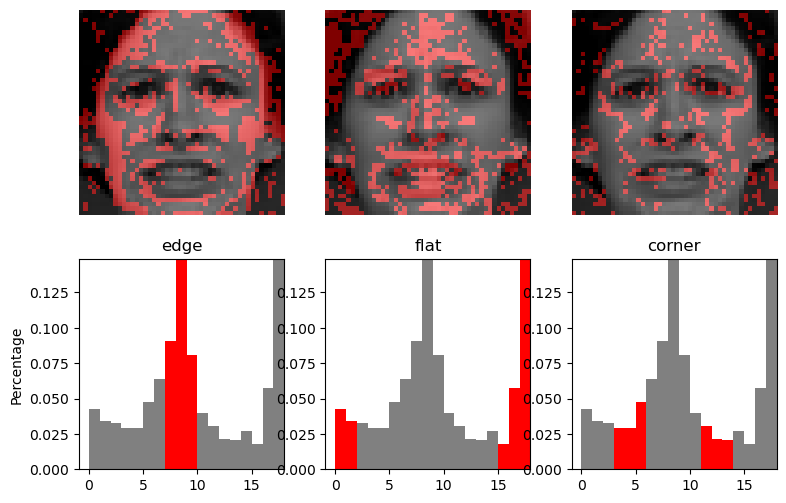

In [14]:
# With radius 2

plot_lbp_example(images[0], 2)

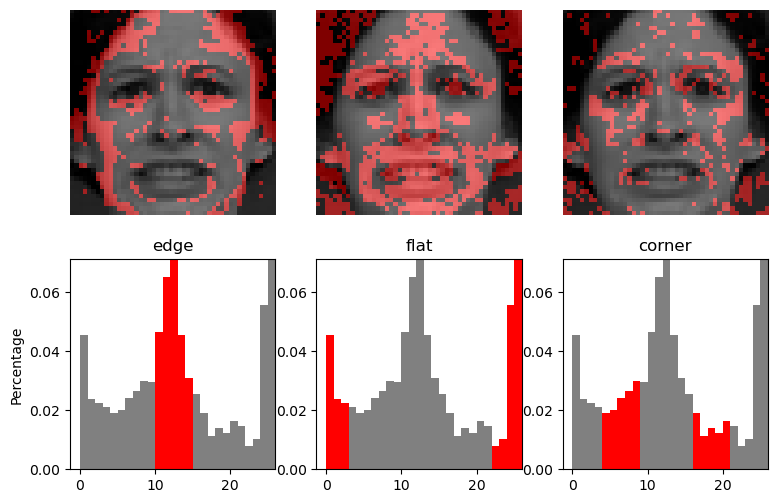

In [15]:
# With radius 3

plot_lbp_example(images[0], 3)

In [16]:
# Extracting lbp features from images

lbp_features = []
    
for image in images:
    lbp_feature = compute_lbp(image, 3)
    lbp_features.append(lbp_feature)

lbp_features = np.array(lbp_features)

In [17]:
# Splitting the dataset into train, test and validation set

train_data, test_data, train_labels, test_labels = train_test_split(lbp_features, labels, test_size=0.3, random_state=12, stratify=labels)

In [18]:
print('Train size: ',  len(train_data))
print('Test size: ',  len(test_data))

Train size:  245
Test size:  106


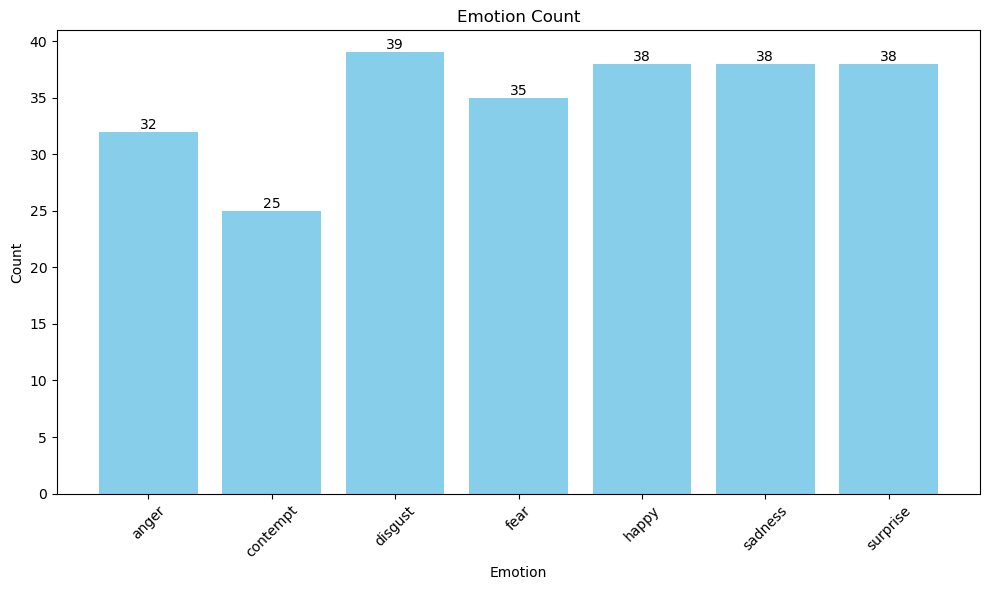

In [19]:
plot_count(train_data, train_labels)

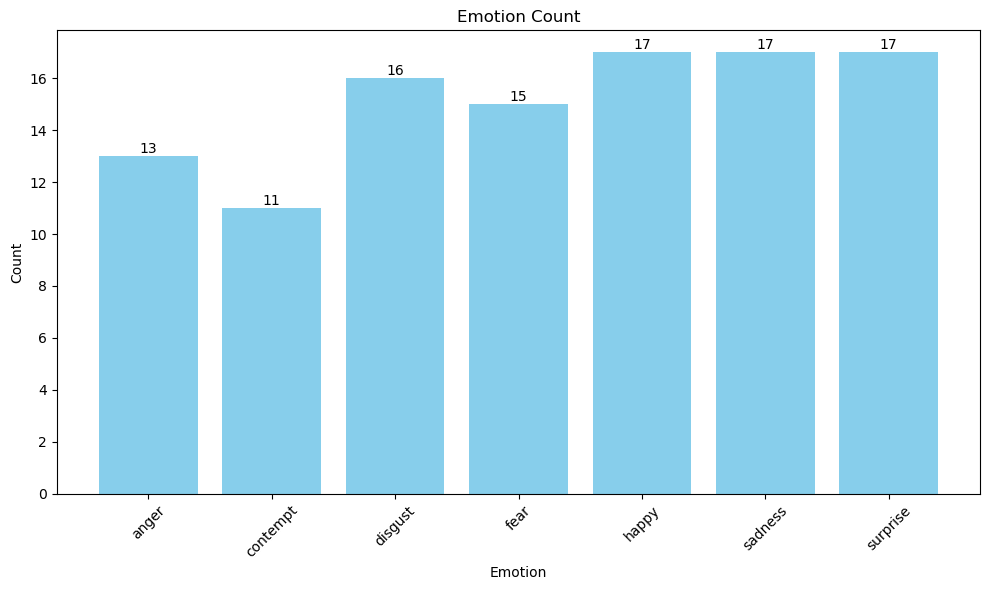

In [20]:
plot_count(test_data, test_labels)

In [21]:
train_data[0]

array([0.04817708, 0.00130208, 0.00130208, 0.00043403, 0.        ,
       0.        , 0.00130208, 0.00303819, 0.        , 0.00043403,
       0.00043403, 0.00043403, 0.00086806, 0.00347222, 0.00173611,
       0.00043403, 0.00043403, 0.        , 0.00173611, 0.00173611,
       0.        , 0.00086806, 0.00043403, 0.00043403, 0.00043403,
       0.00130208, 0.00086806, 0.        , 0.00086806, 0.        ,
       0.        , 0.00086806, 0.00173611, 0.        , 0.00130208,
       0.00043403, 0.00130208, 0.00217014, 0.00347222, 0.00173611,
       0.00043403, 0.        , 0.00043403, 0.00086806, 0.00173611,
       0.        , 0.00043403, 0.00043403, 0.00086806, 0.00173611,
       0.00130208, 0.00130208, 0.00173611, 0.00173611, 0.00043403,
       0.00173611, 0.00086806, 0.        , 0.00086806, 0.00043403,
       0.00130208, 0.00217014, 0.00086806, 0.00043403, 0.00130208,
       0.00086806, 0.00173611, 0.00086806, 0.00086806, 0.00130208,
       0.00043403, 0.00086806, 0.00130208, 0.00043403, 0.00043

In [22]:
train_data.shape

(245, 555)

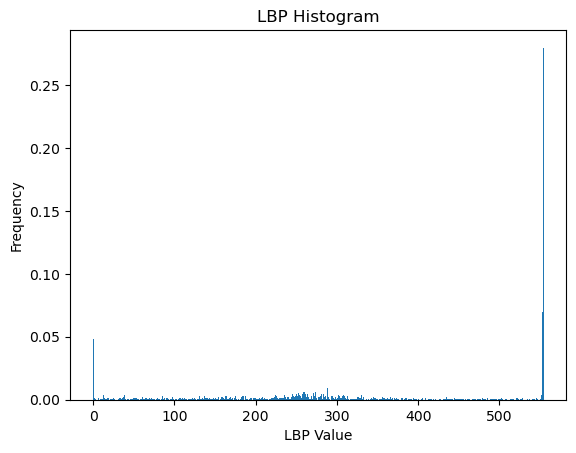

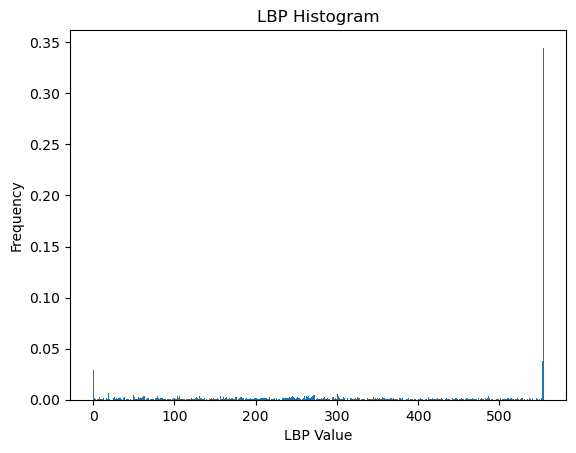

In [23]:
plot_lbp_hist(train_data[0])
plot_lbp_hist(train_data[1])

In [24]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform LBP features
scaler.fit(train_data)
standardized_train_data = scaler.transform(train_data)
standardized_test_data = scaler.transform(test_data)

In [25]:
# Look for best configuration

kernels = ['linear', 'rbf', 'poly', 'sigmoid']
c = [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 10, 1e2, 1e3, 1e4,1e5]
gammas = [0.01, 0.1, 1, 10, 100]

clf = svm.SVC()
clf.fit(standardized_train_data, train_labels)
param_grid = dict(kernel=kernels, C=c, gamma=gammas)

# GridSearchCV accepts dictionary with different hyper-parameters we want to try on the SVM model. 
grid = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1)

grid.fit(standardized_train_data, train_labels)
grid.best_params_

{'C': 0.01, 'gamma': 0.01, 'kernel': 'linear'}

In [26]:
best_c = grid.best_params_['C']
best_gamma = grid.best_params_['gamma']
best_kernel = grid.best_params_['kernel']

In [27]:
model = svm.SVC(kernel=best_kernel, gamma=best_gamma, C=best_c)

model.fit(standardized_train_data, train_labels)

pred_labels = model.predict(standardized_test_data)

generate_report(test_labels, pred_labels)

Confusion matrix: 
 [[ 8  0  0  1  1  1  2]
 [ 1  2  0  2  4  1  1]
 [ 5  0  9  0  2  0  0]
 [ 2  1  1  7  2  0  2]
 [ 1  0  1  1 13  0  1]
 [ 2  1  2  2  0 10  0]
 [ 0  0  2  0  1  2 12]] 
F1 score: 
 0.5650805727038228 
Accuracy: 
 0.5754716981132075 
Classification report: 
               precision    recall  f1-score   support

       anger       0.42      0.62      0.50        13
    contempt       0.50      0.18      0.27        11
     disgust       0.60      0.56      0.58        16
        fear       0.54      0.47      0.50        15
       happy       0.57      0.76      0.65        17
     sadness       0.71      0.59      0.65        17
    surprise       0.67      0.71      0.69        17

    accuracy                           0.58       106
   macro avg       0.57      0.56      0.55       106
weighted avg       0.58      0.58      0.57       106

